In [1]:
import theano
import lasagne
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
import nltk.data

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from nolearn.lasagne import NeuralNet
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import softmax, sigmoid
from sklearn.cross_validation import train_test_split

In [2]:
df = pd.read_csv('data/imdb.csv')

In [3]:
def agrupar_pelis(x):
    if x >=7.5:
        return 2
    elif x<7.5 and x>=6:
        return 1
    else:
        return 0

df['imdb_score'] = df['imdb_score'].apply(agrupar_pelis)

In [4]:
ratings = np.sort(df['imdb_score'].unique())

In [5]:
len(df[df.imdb_score == 0]), len(df[df.imdb_score == 1]),len(df[df.imdb_score == 2])

(1454, 2702, 887)

In [6]:
#df['earning_rate'] = df.apply(lambda r: r.gross / r.budget, axis=1)

In [7]:
a = df.corr()

In [8]:
import matplotlib.pyplot as plt

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [9]:
ac1 = df['actor_1_name'].unique()
ac2 = df['actor_2_name'].unique()
ac3 = df['actor_3_name'].unique()

In [10]:
total = np.concatenate((ac1, ac2, ac3))

In [11]:
total = dict(enumerate(set(total)))

In [12]:
def factorizar(row):
    for x in total:
        if total[x] == row:
            return int(x)

In [13]:
df['actor_1_name'] = df['actor_1_name'].apply(lambda row: factorizar(row))
df['actor_2_name'] = df['actor_2_name'].apply(lambda row: factorizar(row))
df['actor_3_name'] = df['actor_3_name'].apply(lambda row: factorizar(row))

In [14]:
## Para obtener los indices de los paises y los lenguajes de las peliculas
idx_language, label_language = pd.factorize(df['language'])
idx_country, label_country = pd.factorize(df['country'])

## Para obtener los indices de los actores
#idx_actor1, label_actor1 = pd.factorize(df['actor_1_name'])
#idx_actor2, label_actor2 = pd.factorize(df['actor_2_name'])
#idx_actor3, label_actor3 = pd.factorize(df['actor_3_name'])

## Para obtener el indice del director
idx_director, label_director = pd.factorize(df['director_name'])

#Para obtener los indices del titulo de las peliculas y el content rating
idx_movie, label_movie = pd.factorize(df['movie_title'])
idx_content, label_content = pd.factorize(df['content_rating'])

In [15]:
## Separa los generos en columnas
df = pd.concat([df, df.genres.str.get_dummies(sep='|')], axis=1)

In [16]:
df_separados = pd.DataFrame()
df_separados = pd.concat([df_separados, df.plot_keywords.str.replace('|',' ')],axis=1)

nltk.data.path = ['nltk_data/']

stopw = set(stopwords.words('english')) 
corpus = []
for e in df_separados.values:
    if type(e[0]) is str:
        corpus.append(e[0])
corpus1 = " ".join(corpus)
corpus1 = corpus1.split(" ")

In [17]:
corpus1 = list(filter(lambda x: not x[0] in stopw, corpus1))
corpus1 = set(corpus1)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary = corpus1
vect = TfidfVectorizer(sublinear_tf=True, max_df=2, analyzer='word', 
           stop_words=stopw, vocabulary=vocabulary)
vect.fit(corpus)
#print(dict(zip(vect.get_feature_names(), vect.idf_)))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=2, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'itself', 'hadn', 'which', 'too', 'couldn', 'doesn', 'under', 'has', 'himself', 'in', 'hasn', 'haven', 'isn', 'themselves', 'nor', 'further', 'yourselves', 'their', 'an', 'ma', 'above', 'from', 'herself', 'am', 'at', 'other', 'ourselves', 'does', 'then', 'only', 'ain', 'the', 'through', ...all', 'those', 're', 'y', 'while', 'do', 'there', 'with', 'we', 'be', 'until', 'your', 'as', 'whom'},
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary={'godparent', 'jeet', 'gorilla', 'corpse', 'uprising', 'chernobyl', 'nomad', 'washington', 'hoodoo', 'los', 'landlady', 'primate', 'generation', 'cabinet', 'pride', 'eg

In [19]:
def transformar_keywords(k):
    if not type(k) is str:
        return 0  
    keywords = k.replace('|'," ")
    doc_tfidf = vect.transform([k])
    t = doc_tfidf.toarray().sum()
    return t

In [20]:
df['plot_keywords'] = df['plot_keywords'].apply(lambda row: transformar_keywords(row)) 

In [21]:
df['language'] = idx_language
df['country'] = idx_country
#df['actor_1_name'] = idx_actor1
#df['actor_2_name'] = idx_actor2
#df['actor_3_name'] = idx_actor3
df['director_name'] = idx_director
df['movie_title'] = idx_movie
df['content_rating'] = idx_content

In [22]:
df.fillna(value=-1, inplace=True)

In [23]:
y = df['imdb_score']
df.drop('imdb_score', axis=1, inplace=True)

### Columnas Dropeadas

In [24]:
#df.columns

In [25]:
#df.drop('actor_1_facebook_likes', axis=1, inplace=True)
#df.drop('actor_2_facebook_likes', axis=1, inplace=True)
#df.drop('actor_3_facebook_likes', axis=1, inplace=True)
#df.drop('director_facebook_likes', axis=1, inplace=True)

#df.drop('director_name', axis=1, inplace=True)
#df.drop('actor_1_name', axis=1, inplace=True)
#df.drop('actor_2_name', axis=1, inplace=True)
#df.drop('actor_3_name', axis=1, inplace=True)

#df.drop('cast_total_facebook_likes', axis=1, inplace=True)
#df.drop('movie_facebook_likes', axis=1, inplace=True)
#df.drop('budget', axis=1, inplace=True)
#df.drop('gross', axis=1, inplace=True)
#df.drop('cast_total_facebook_likes', axis=1, inplace=True)
#df.drop('plot_keywords', axis=1, inplace=True)
df.drop('genres', axis=1, inplace=True)
df.drop('movie_imdb_link', axis=1, inplace=True)
df.drop('color', axis=1, inplace=True)
#df.drop('num_user_for_reviews', axis=1, inplace=True)
#df.drop('movie_title', axis=1, inplace=True)
#df.drop('content_rating', axis=1, inplace=True)
#df.drop('duration', axis=1, inplace=True)

In [43]:
xs = x = df.values
ys = y

## Matriz de Correlación Full

In [27]:
a = df.corr()

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


# PCA

In [44]:
from sklearn.decomposition import RandomizedPCA # using randomized Singular Value Decomposition 
Xp = RandomizedPCA(n_components=35, random_state=1)
Xp = Xp.fit_transform(xs)

In [45]:
#Xp.explained_variance_ratio_.cumsum()

In [46]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


def plot_matrix(clf, X_test, y_test):
    plt.clf()
    plt.imshow(confusion_matrix(clf.predict(X_test), y_test),
               interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    plt.show()

             precision    recall  f1-score   support

          0       0.77      0.62      0.69       379
          1       0.70      0.86      0.77       658
          2       0.82      0.57      0.67       224

avg / total       0.75      0.74      0.73      1261

Score over Testing Data 0.7351308485329104
Score over Training Data 1.0


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


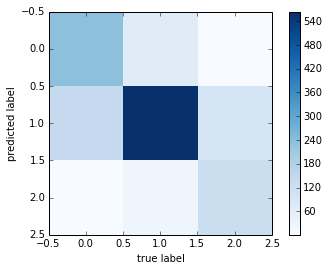

In [48]:
%matplotlib inline
clf = ExtraTreesClassifier(n_estimators=300,
                           max_features=0.2, 
                           n_jobs=2,
                           max_depth=None,
                           min_samples_split=1,
                           random_state=1).fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))
print("Score over Testing Data {}".format(clf.score(X_test, y_test)))
print("Score over Training Data {}".format(clf.score(X_train, y_train)))
plot_matrix(clf, X_test, y_test)

(50,)


(0, 50)

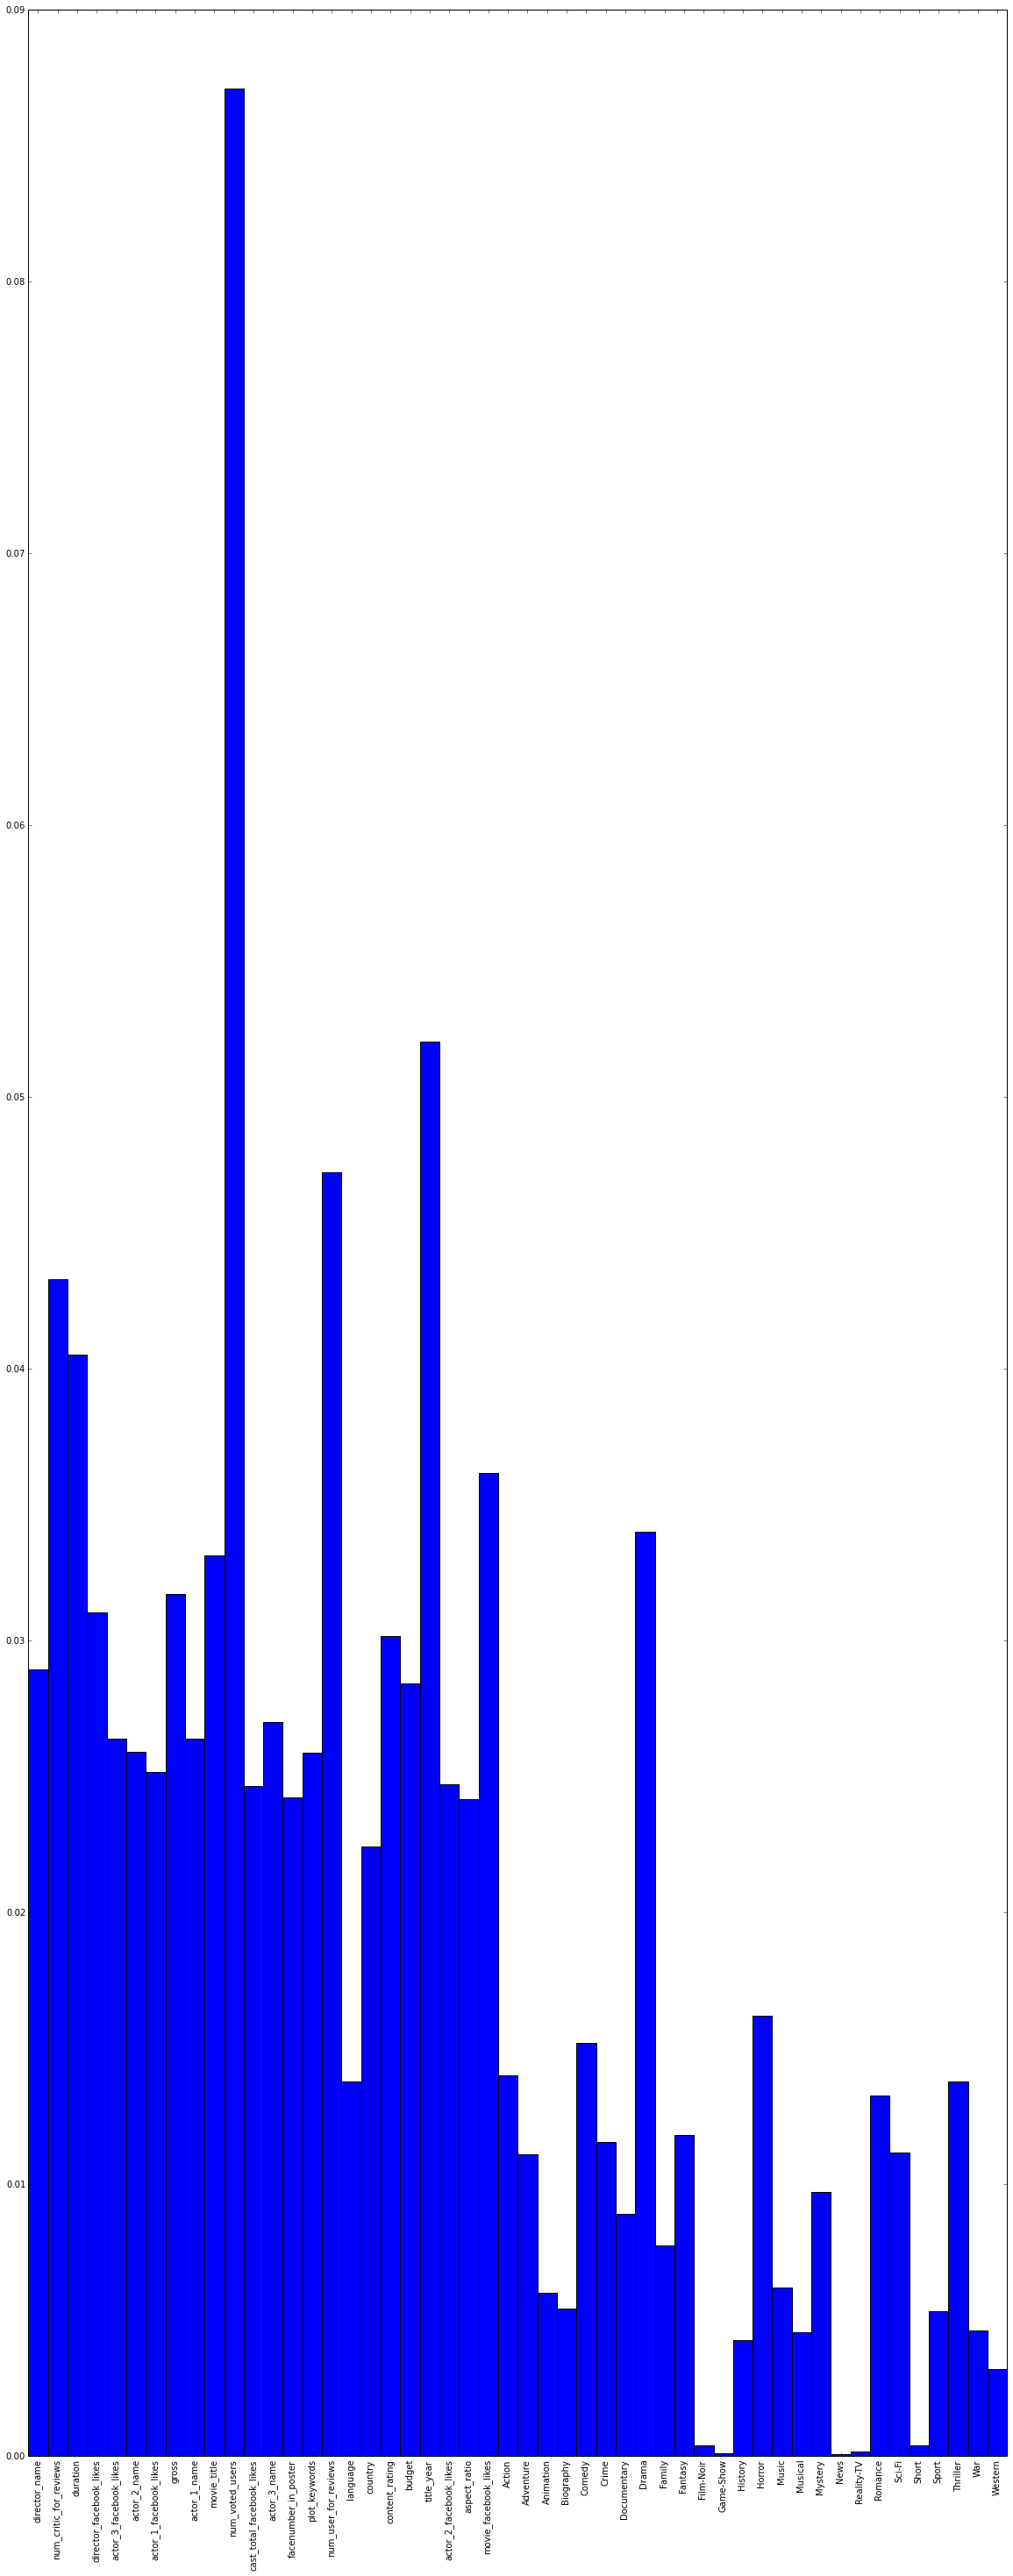

In [49]:
importances = clf.feature_importances_
cols = len(df.columns)

text = list(map(lambda i: df.columns[i], range(cols)))
plt.figure(figsize=(20,cols))
print(importances[::-1].shape)
plt.bar(range(cols),height=importances,  width=1.)
plt.xticks(np.arange(0.5, cols, 1.), text, rotation=90)
plt.xlim((0, cols))
#plt.show()

In [50]:
confusion_matrix(y_test, clf.predict(X_test))

array([[236, 142,   1],
       [ 67, 564,  27],
       [  2,  95, 127]])

## Dummy

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


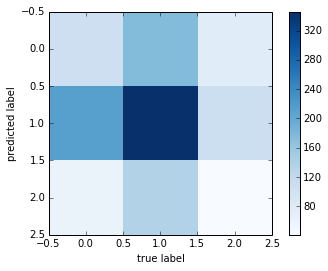

             precision    recall  f1-score   support

          0       0.30      0.28      0.29       379
          1       0.52      0.53      0.52       658
          2       0.17      0.18      0.18       224

avg / total       0.39      0.39      0.39      1261



In [51]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(random_state=0).fit(X_train, y_train)
#print clf.score(X_test, y_test)
plot_matrix(clf, X_test, y_test)
clf.score(X_test, y_test)
print(classification_report(y_test, clf.predict(X_test)))

In [52]:
confusion_matrix(y_test, clf.predict(X_test))

array([[106, 212,  61],
       [175, 346, 137],
       [ 76, 107,  41]])

## SVM

             precision    recall  f1-score   support

          0       1.00      0.03      0.06       379
          1       0.53      1.00      0.69       658
          2       1.00      0.03      0.05       224

avg / total       0.75      0.54      0.39      1261

0.536082474227


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


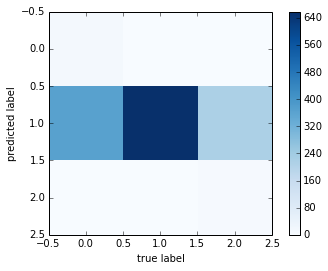

In [37]:
from sklearn.svm import SVC

sv = SVC(kernel='rbf', cache_size=1000)
sv.fit(X_train, y_train)

print(classification_report(y_test, sv.predict(X_test)))
print(sv.score(X_test, y_test))
plot_matrix(sv, X_test, y_test)

In [40]:
confusion_matrix(y_test, sv.predict(X_test))

array([[ 12, 367,   0],
       [  0, 658,   0],
       [  0, 218,   6]])

# Red Neuronal

In [426]:
from lasagne.nonlinearities import linear, tanh, rectify
from sklearn.metrics import classification_report, confusion_matrix

In [427]:
xs = x
ys = np.array(y)

In [428]:
std_x = MinMaxScaler([-1, 1])
xs = std_x.fit_transform(np.array(xs))
std_y = MinMaxScaler([0, 2])
ys = std_y.fit_transform(np.array(ys))

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [429]:
layers_0 = [
                (InputLayer, {'shape': (None, 50)}),
                (DenseLayer, {'num_units': 512}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 512}),
                (DropoutLayer, {'p': 0.5}),
                (DenseLayer, {'num_units': 3, 'nonlinearity': softmax}),
        ]

In [430]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [448]:
def create_network(npochs=50, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.009)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.09, stop=0.009),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

#net0 = create_network(10)

In [449]:
#theano.config.profile = True


In [450]:
net0 = create_network(60)

# Neural Network with 290307 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input0        50
  1  dense1       512
  2  dropout2     512
  3  dense3       512
  4  dropout4     512
  5  dense5         3

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     1.12150     1.05716    1.06086      0.42668  0.41s
      2     1.10150     1.11312    0.98956      0.54029  0.40s
      3     1.14741     1.03667    1.10683      0.41083  0.38s
      4     1.07175     0.97570    1.09844      0.54029  0.40s
      5     1.02057     0.96226    1.06060      0.54161  0.38s
      6     0.99228     0.95376    1.04039      0.54954  0.43s
      7     0.98434     0.94563    1.04094      0.55482  0.37s
      8     0.97138     0.93885    1.03465      0.55218  0.37s
      9     0.96158     0.93143    1.03237      0.55482  0.37s
     10     0.95027     0.92458    1.02779      0.55746  0.

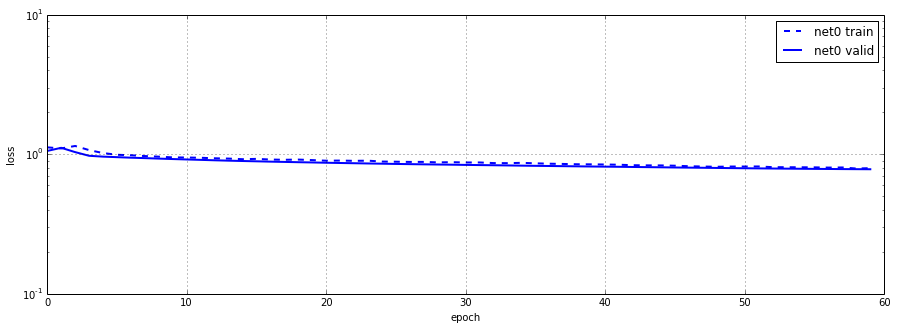

In [451]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

net0.fit(X_train, y_train)
plot_loss_net(net0)

In [452]:
%matplotlib inline

def plot_loss_net(net0):
    plt.clf()
    plt.figure(figsize=(15,5))

    train_loss = np.array([i["train_loss"] for i in net0.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
    plt.plot(train_loss, '--b', linewidth=2, label="{} train".format("net0"))
    plt.plot(valid_loss, '-b', linewidth=2, label="{} valid".format("net0"))

    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

             precision    recall  f1-score   support

          0       0.62      0.61      0.61       379
          1       0.65      0.74      0.69       658
          2       0.69      0.45      0.54       224

avg / total       0.65      0.65      0.64      1261



/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


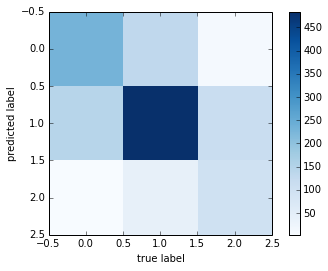

In [453]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

print(classification_report(y_test, net0.predict(X_test)))
plot_matrix(net0, X_test, y_test)

# <span style="color:red"> VER ESTO!! NO ESTA TOMANDO LOS ELEMENTOS DE LAS CLASES 0 Y 2</span>.

In [454]:
confusion_matrix(y_test, net0.predict(X_test))

array([[231, 145,   3],
       [132, 484,  42],
       [ 10, 114, 100]])